In [1]:
pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from fuzzywuzzy import process

C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
import sqlite3

conn = sqlite3.connect('lipstick.db')
cursor = conn.cursor()

cursor.execute("SELECT product_name, actual_price, discount_price,discount_percentage FROM lipstick")
data1 = cursor.fetchall()

# Query data from Table2
cursor.execute("SELECT product_name, actual_price, discount_price,discount_percentage FROM Tata")
data2 = cursor.fetchall()

# Convert fetched data into DataFrames
df1 = pd.DataFrame(data1, columns=[ 'product_name', 'actual_price', 'discount_price','discount_percentage'])
df2 = pd.DataFrame(data2, columns=[ 'product_name', 'actual_price', 'discount_price','discount_percentage'])
# Close the database connection
conn.close()

In [4]:
df1['actual_price'] = pd.to_numeric(df1['actual_price'], errors='coerce')
df2['actual_price'] = pd.to_numeric(df2['actual_price'], errors='coerce')

In [5]:
from fuzzywuzzy import process

# Fuzzy matching function
def match_product_names(name, choices, scorer):
    """Match a single product name to a list of choices using a specified scorer."""
    match = process.extractOne(name, choices, scorer=scorer)
    if match:
        return match[0], match[1]  # Return only the name and score
    else:
        return None, 0  # If no match is found, return None and score 0

# Apply fuzzy matching to find the closest product names
matches = df2['product_name'].apply(lambda x: match_product_names(x, df1['product_name'], process.fuzz.partial_ratio))
df2['matched_product_name'] = matches.apply(lambda x: x[0])
df2['score'] = matches.apply(lambda x: x[1])

# Filter out matches with low scores (threshold can be adjusted)
threshold = 80
df2_filtered = df2[df2['score'] >= threshold]

In [6]:
# Merge the dataframes on matched product names
comparison_df = pd.merge(df1, df2_filtered, left_on='product_name', right_on='matched_product_name', suffixes=('_lipstick', '_Tata'))

# Calculate the price difference
comparison_df['price_difference'] = comparison_df['actual_price_lipstick'] - comparison_df['actual_price_Tata']

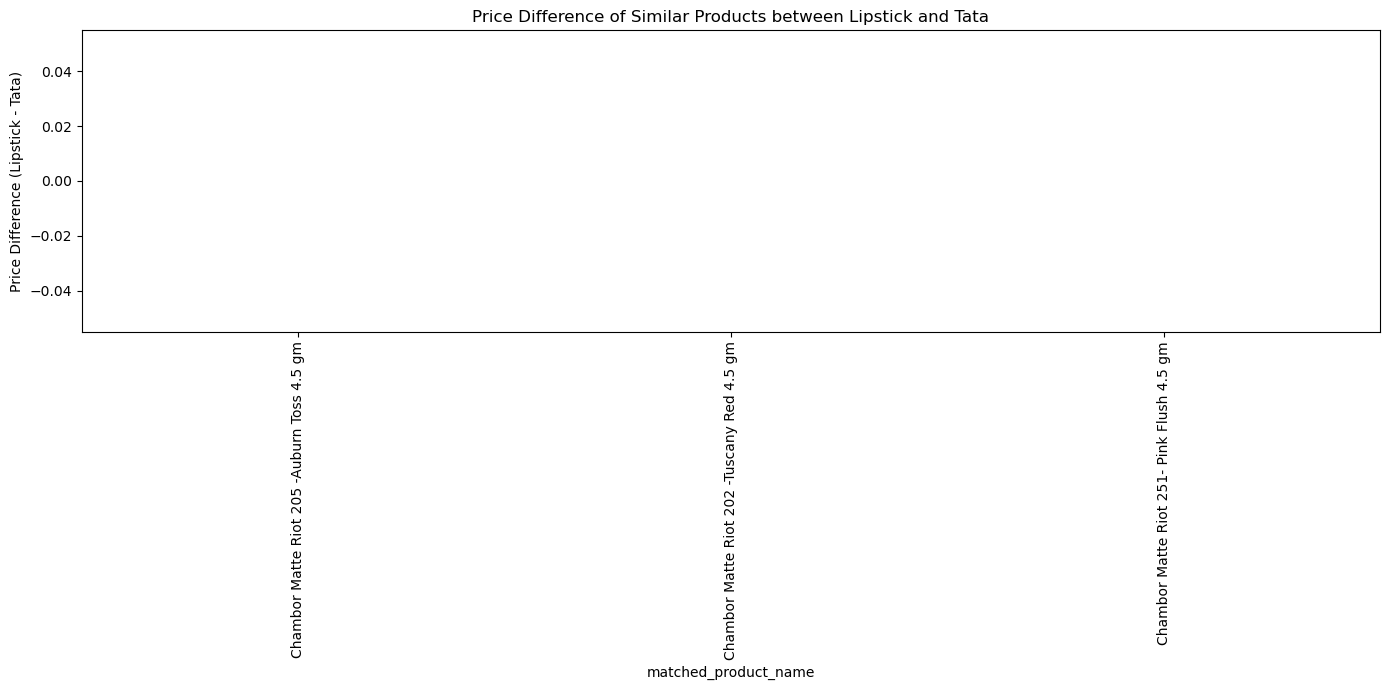

In [14]:
plt.figure(figsize=(14, 7))
sns.barplot(x='matched_product_name', y='price_difference', data=comparison_df)
plt.xticks(rotation=90)
plt.title('Price Difference of Similar Products between Lipstick and Tata')
plt.xlabel('matched_product_name')
plt.ylabel('Price Difference (Lipstick - Tata)')
plt.tight_layout()
plt.show()